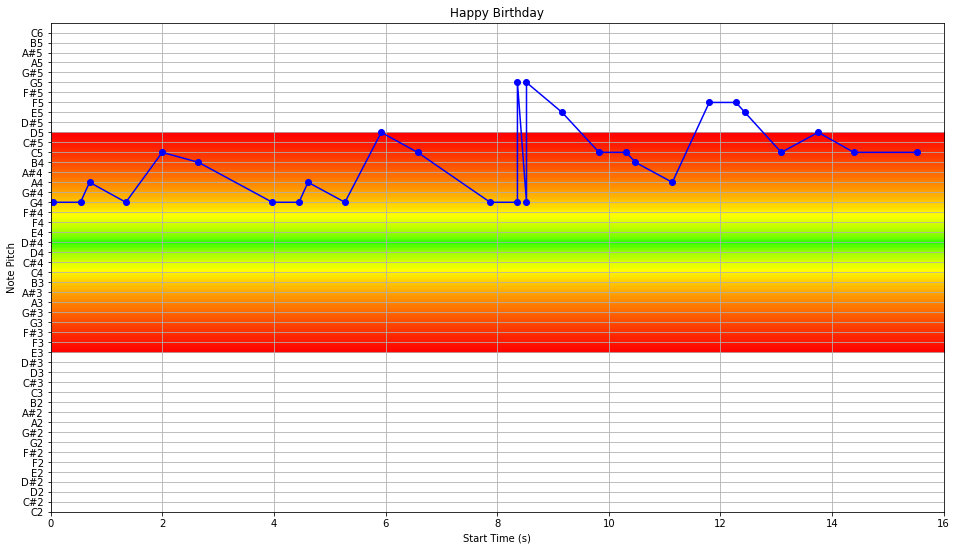

   start_time_s  end_time_s  pitch_midi  velocity pitch_name  duration
0     15.531527   15.531527          72       106         C5  0.000000
1     14.393749   15.531527          72       106         C5  1.137778
2     13.753917   14.393749          74       104         D5  0.639833
3     13.092148   13.765527          72       101         C5  0.673379
4     12.441989   13.092148          76       102         E5  0.650159


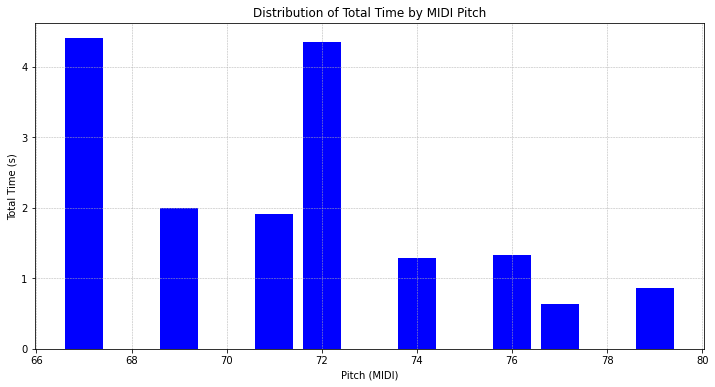

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from constants import MIDI_NOTES
from matplotlib.colors import LinearSegmentedColormap, Normalize

def clean_data(file_path):
    data = pd.read_csv(file_path)
    data = data.drop(columns=['pitch_bend'])
    data['pitch_name'] = data['pitch_midi'].map(MIDI_NOTES)

    # repeat last data point to show the end of the song
    first_entry = data.iloc[0].copy()
    first_entry['start_time_s'] = data.iloc[0]['end_time_s']
    first_entry_df = pd.DataFrame([first_entry])
    data = pd.concat([first_entry_df, data], ignore_index=True)

    return data


def plot_pitch_over_time(data, title, voice_part):
    plt.figure(figsize=(16, 9))
    plt.title(title)
    plt.grid(True)
    plt.plot(data['start_time_s'], data['pitch_midi'], marker='o', linestyle='-', color='b')
    
    # x-axis
    X_MIN = 0
    X_MAX = int(data['start_time_s'].max()) + 1  # round up
    plt.xlabel('Start Time (s)')
    plt.xlim(X_MIN, X_MAX)

    # voice part bounds
    if voice_part == 'soprano':
        Y_VOICE_MIN = 59
        Y_VOICE_MID = 70
        Y_VOICE_MAX = 81
    elif voice_part == 'alto':
        Y_VOICE_MIN = 52
        Y_VOICE_MID = 63
        Y_VOICE_MAX = 74
    elif voice_part == 'tenor':
        Y_VOICE_MIN = 47
        Y_VOICE_MID = 58
        Y_VOICE_MAX = 69
    elif voice_part == 'baritone':
        Y_VOICE_MIN = 43
        Y_VOICE_MID = 54
        Y_VOICE_MAX = 65
    else:
        Y_VOICE_MIN = 55
        Y_VOICE_MID = 61
        Y_VOICE_MAX = 67

    # y-axis
    Y_PLOT_MIN = 36
    Y_PLOT_MAX = 85
    plt.ylabel('Note Pitch')
    plt.ylim(Y_PLOT_MIN, Y_PLOT_MAX)
    y_ticks = range(Y_PLOT_MIN, Y_PLOT_MAX)
    y_labels = [MIDI_NOTES[num] for num in y_ticks]
    plt.yticks(ticks=y_ticks, labels=y_labels)

    # Set up custom function for shade class
    NUM_SHADED_REGIONS = 100
    color_grad = ['#00FF00', '#FFFF00', '#FF0000'] # Green to Yellow to Red
    color_map = LinearSegmentedColormap.from_list("custom_gradient", color_grad)

    class CustomNorm(Normalize):
        def __call__(self, value, clip=None):
            norm_value = np.sqrt((value - self.vmin) / (self.vmax - self.vmin)) # CUSTOM normalization FUNCTION HERE
            return np.clip(norm_value, 0, 1)  # Ensure it is in the range [0, 1]

    ### TOP SHADE
    y_top = np.linspace(Y_VOICE_MID, Y_VOICE_MAX, NUM_SHADED_REGIONS)
    custom_norm_top = CustomNorm(vmin=Y_VOICE_MID, vmax=Y_VOICE_MAX)
    for i in range(NUM_SHADED_REGIONS):
        plt.fill_betweenx(y_top[i:i+2], X_MIN, X_MAX, color=color_map(custom_norm_top(y_top[i])))

    ### BOTTOM SHADE
    y_bottom = np.linspace(Y_VOICE_MIN, Y_VOICE_MID, NUM_SHADED_REGIONS)
    custom_norm_bottom = CustomNorm(vmin=Y_VOICE_MID, vmax=Y_VOICE_MIN)
    for i in range(NUM_SHADED_REGIONS):
        plt.fill_betweenx(y_bottom[i:i+2], X_MIN, X_MAX, color=color_map(custom_norm_bottom(y_bottom[i])))

    # final result!
    plt.show()
    return
    
def plot_pitch_frequency(data):
    # Calculate the duration for each note
    data['duration'] = data['end_time_s'] - data['start_time_s']
    print(data.head())

    # Aggregate total duration by pitch_midi
    pitch_duration = data.groupby('pitch_midi')['duration'].sum().reset_index()

    # Plot the distribution of total time for each pitch
    plt.figure(figsize=(12, 6))
    plt.bar(pitch_duration['pitch_midi'], pitch_duration['duration'], color='b')
    plt.title('Distribution of Total Time by MIDI Pitch')
    plt.xlabel('Pitch (MIDI)')
    plt.ylabel('Total Time (s)')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()
    return

# hbd_path = 'data/songs_voice_midi/Happy_Birthday_Cleaned.csv'
hbd_path = os.getcwd() + '/Happy_Birthday_Cleaned.csv'
hbd_data = clean_data(hbd_path)
plot_pitch_over_time(data=hbd_data, title='Happy Birthday', voice_part='alto')
plot_pitch_frequency(hbd_data)


In [10]:
# web scraping